In [1]:
import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
# filename='christiner3.bmp'
file1,file2='e',1

In [3]:
def get_random_file(root_folder, exclude_folder=[]):
    # Get a list of all files (recursively) in the folder
    all_files = []
    for foldername, subfolders, filenames in os.walk(root_folder):
        # Exclude the specified folder
        if exclude_folder in subfolders:
            subfolders.remove(exclude_folder)

        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            all_files.append(file_path)

    # Check if there are any files in the folder
    if not all_files:
        print("No files found in the specified folder.")
        return None

    # Choose a random file
    random_file = random.choice(all_files)

    return random_file


In [4]:
folder_path = os.path.join('Images','IITD-Database')
# folder_path = os.path.join('Images','MMU-Iris-Database')

exclude_folder_name = ['Normalized_Images']
# filepath='Images/MMU-Iris-Database/12/left/kelvinl1.bmp'
filepath='Images/IITD-Database/002/01_L.bmp'

random_file_path = get_random_file(folder_path, exclude_folder_name)

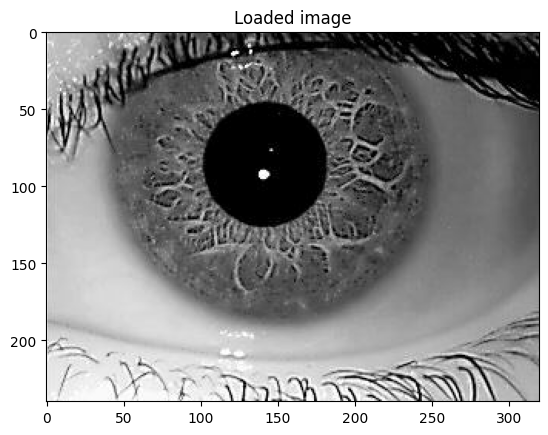

In [5]:
main_image = cv.imread(random_file_path)
main_image_backup= cv.imread(random_file_path)
if main_image is None:
    print ('Error opening image!')
    print ('Usage: hough_circle.py [image_name -- default ' + random_file_path + '] \n')

#opencv stores image in BGR format and matplot lib expects it in RGB
plt.title("Loaded image")
plt.imshow(cv.cvtColor(main_image,cv.COLOR_BGR2RGB))

rows=240,cols=320


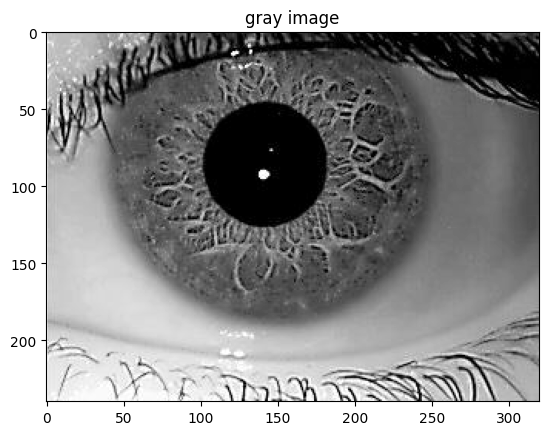

In [6]:
# Convert it to gray
gray_image = cv.cvtColor(main_image, cv.COLOR_BGR2GRAY)
rows,cols= gray_image.shape
print(f"rows={rows},cols={cols}")
plt.title("gray image")
plt.imshow(gray_image,cmap='grey')

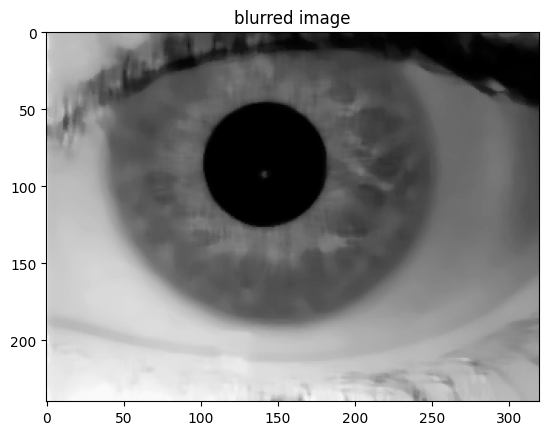

In [11]:
# Reduce the noise to avoid false circle detection
median_blurred_image = cv.medianBlur(gray_image, 9)
plt.title("blurred image")
plt.imshow(median_blurred_image,cmap='grey')

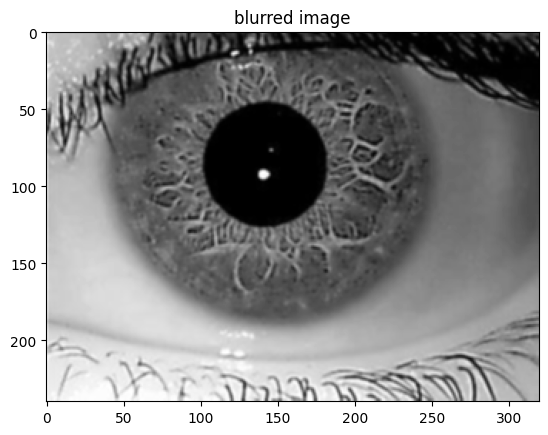

In [12]:
# Reduce the noise to avoid false circle detection
#  if sigmaY is zero, it is set to be equal to sigmaX, if both sigmas are zeros, they are computed from 
# ksize.width and ksize.height, respectively (see getGaussianKernel for details); to fully control the 
# result regardless of possible future modifications of all this semantics, it is recommended to specify all of ksize, 
# sigmaX, and sigmaY.
gaussian_blurred_image = cv.GaussianBlur(gray_image,ksize=(3,3),sigmaX=0,sigmaY=0)
plt.title("blurred image")
plt.imshow(gaussian_blurred_image,cmap='grey')

In [26]:
chosen_image=median_blurred_image

In [27]:
#use hough transform to calulate circles of certain radius
#iit ko lagi 20-80
#arko ko lagi 10-40

circles = cv.HoughCircles(chosen_image, cv.HOUGH_GRADIENT, dp=1, minDist=rows/8,
                           param1=100, param2=30,
                           minRadius=20, maxRadius=80)
if(type(circles) == None):
    raise Exception("No circles detected. Error")

In [28]:
if(len(circles)>1):
    raise Exception("Multiple circles detected. Error")

if(len(circles)<1):
    raise Exception("No circles detected. Error")

circles = np.uint16(np.around(circles))

pupil_center = (circles[0,0,0], circles[0,0,1])
# circle center
cv.circle(main_image, pupil_center, 1, (255, 0, 255), 1)
# circle outline
pupil_radius = circles[0,0,2]
cv.circle(main_image, pupil_center, pupil_radius, (255, 0, 255), 1)

print(f"pupil_center={pupil_center},pupil_radius={pupil_radius}")

pupil_center=(182, 94),pupil_radius=41


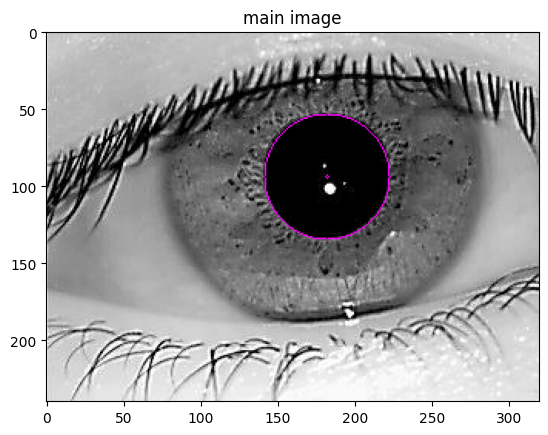

In [29]:
plt.title("main image")
plt.imshow(main_image)

## Sum of intensities over all radius


In [30]:
arr=np.array(chosen_image).reshape(rows,cols).astype(int)
arr.shape

(240, 320)

In [31]:
xc,yc=pupil_center[0],pupil_center[1]
xc,yc

(182, 94)

In [32]:
radius_range = range(int(pupil_radius*1.4),int(pupil_radius*2.4))
radius_range

range(57, 98)

In [33]:
intensity_sum = np.zeros(len(radius_range))

for i, radius in enumerate(radius_range):
    for theta in range(0, 360):  # Iterate over all angles
        # Convert polar coordinates to Cartesian coordinates
        x = int(xc + radius * np.cos(np.deg2rad(theta)))
        y = int(yc - radius * np.sin(np.deg2rad(theta)))  # Negative sign for y-component

        # Ensure the coordinates are within the image bounds
        if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:
            intensity_sum[i] += arr[y, x]

In [34]:
Rr = radius_range[0]
max_val = float('-inf')

for i in range(2, len(intensity_sum) - 2):
    val = intensity_sum[i + 2] + intensity_sum[i + 1] - intensity_sum[i - 1] - intensity_sum[i - 2]
    if val > max_val and (radius_range[i] - pupil_radius) > 40:
        max_val = val
        Rr = radius_range[i]  # Update Rr to the corresponding radius value

print("Final Rr:", Rr)


Final Rr: 93


In [35]:
iris_radius=Rr
iris_radius

93

In [36]:
cpy_img=main_image.copy()
cv.circle(cpy_img, pupil_center, int(iris_radius), (255, 0, 255), 1)
iris_radius,pupil_radius

(93, 41)

## if r1-r2 < some threshold go for next big I value

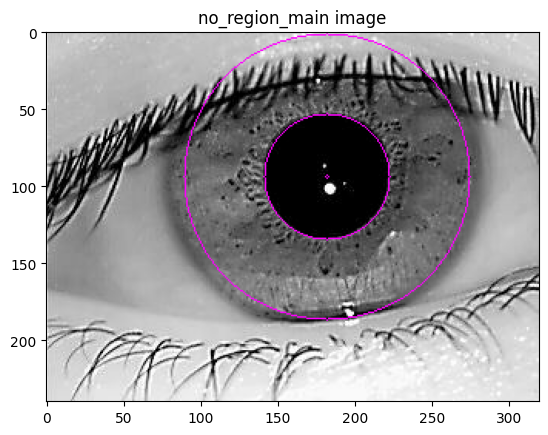

In [37]:
plt.title("no_region_main image")
plt.imshow(cpy_img)

# Sobel Filter

In [38]:
arr=np.array(chosen_image).reshape(rows,cols).astype(int)
arr.shape

(240, 320)

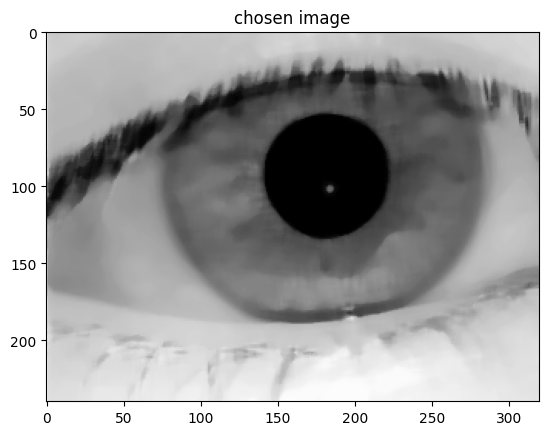

In [39]:
plt.title("chosen image")
plt.imshow(arr,cmap='grey')

In [40]:
#search regions:
length = pupil_radius*2
height = iris_radius-pupil_radius
xc,yc=pupil_center[0],pupil_center[1]
(xc,yc),(length,height)

((182, 94), (82, 52))

In [41]:
cpy_img=main_image.copy()
start_point_upper=(int(xc-length/2),yc-iris_radius)
end_point_upper=(int(xc+length/2),yc-pupil_radius-5)
cv.rectangle(cpy_img, start_point_upper,end_point_upper, (255, 0, 255))
start_point_upper,end_point_upper

((141, 1), (223, 48))

In [42]:
start_point_lower=(int(xc-length/2),yc+iris_radius)
end_point_lower=(int(xc+length/2),yc+pupil_radius+5)
cv.rectangle(cpy_img, start_point_lower,end_point_lower, (255, 0, 255))
start_point_lower,end_point_lower

((141, 187), (223, 140))

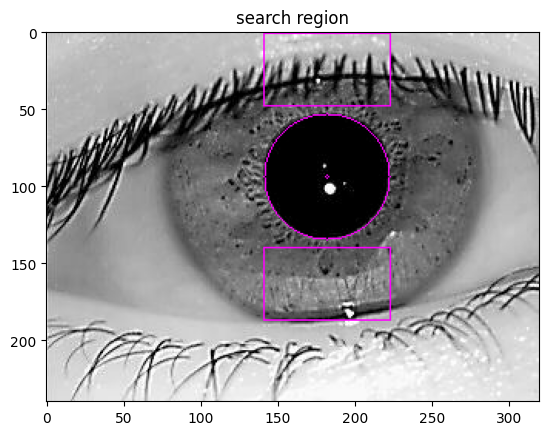

In [43]:
plt.title("search region")
plt.imshow(cpy_img)

In [44]:
# Example usage:
xmin, ymin = start_point_upper
xmax, ymax = end_point_upper

# Ensure xmin and ymin are non-negative
xmin = max(0, xmin)
ymin = max(0, ymin)

# Ensure xmax and ymax are non-negative
xmax = max(0, xmax)
ymax = max(0, ymax)


In [45]:
sobel_matrix = np.zeros((ymax - ymin, xmax - xmin))  # Note the transposed dimensions, number of rows = ymax-ymin

for i in range(ymin, ymax):
    for j in range(xmin, xmax):
        sobel_matrix[i - ymin][j - xmin] = abs(\
            -arr[i - 1][j - 1] - 2 * arr[i][j - 1] - arr[i + 1][j - 1] + \
            arr[i - 1][j + 1] + 2 * arr[i][j + 1] + arr[i + 1][j + 1])  # Transposed indexing

sobel_matrix

array([[ 9.,  4.,  0., ...,  9.,  4.,  3.],
       [ 8.,  4.,  1., ...,  9.,  6.,  3.],
       [ 7.,  4.,  4., ..., 11.,  5.,  2.],
       ...,
       [ 4., 14., 19., ...,  1.,  0.,  4.],
       [ 3.,  5., 10., ...,  0.,  0.,  3.],
       [ 2.,  0.,  2., ...,  0.,  1.,  2.]])

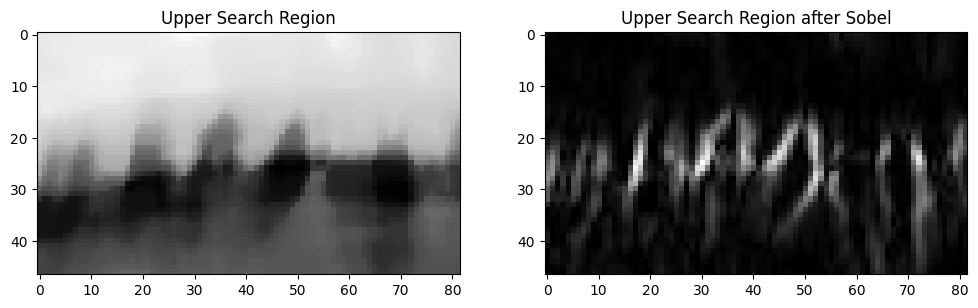

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot chosen image
axs[0].set_title("Upper Search Region")
axs[0].imshow(arr[ymin:ymax, xmin:xmax], cmap='gray')

# Plot upper search region
axs[1].set_title("Upper Search Region after Sobel")
axs[1].imshow(sobel_matrix, cmap='gray')

plt.show()

In [47]:
#for iit 1000000
# threshold = 1000000  # Adjust threshold as needed or make threshold from 0 to 1
threshold=0.05

In [48]:
# Example usage:
eyelid_row_upper = None

region_of_interest = sobel_matrix

# Sum pixel values along each row to count edge points
# Sum pixel values along each row to count edge points
edge_counts = np.sum(region_of_interest, axis=1)

# Sum of all edge counts
total_edge_count = np.sum(edge_counts)

# Normalize edge counts by dividing by the total sum
edge_counts_normalized = edge_counts / total_edge_count

# Find the maximum edge count
max_edge_row_upper = int(np.argmax(edge_counts_normalized))

print(edge_counts)
print(edge_counts_normalized)
print(edge_counts_normalized[max_edge_row_upper])
# Set the threshold (between 0 and 1)

# Check if the maximum normalized edge count exceeds the threshold
if edge_counts_normalized[max_edge_row_upper] >= threshold:
    # Eyelid detected, add the boundary row to the list
    eyelid_row_upper = ymin + max_edge_row_upper
    print(edge_counts_normalized[max_edge_row_upper])

print("Eyelid Row upper:", eyelid_row_upper)


[ 709.  632.  565.  487.  450.  454.  457.  451.  418.  380.  343.  328.
  388.  497.  703. 1059. 1602. 2246. 2925. 3451. 3874. 4525. 5388. 6121.
 6516. 6451. 5869. 5159. 4395. 3787. 3409. 3243. 3089. 2736. 2381. 2190.
 2025. 1838. 1744. 1696. 1542. 1316. 1172. 1061. 1008.  973.  936.]
[0.00688423 0.00613658 0.00548602 0.00472866 0.0043694  0.00440824
 0.00443737 0.00437911 0.00405869 0.00368971 0.00333045 0.00318481
 0.00376739 0.00482576 0.00682597 0.01028265 0.01555506 0.02180815
 0.02840109 0.03350843 0.03761567 0.04393673 0.05231627 0.05943353
 0.06326889 0.06263776 0.05698667 0.05009273 0.04267446 0.03677092
 0.03310062 0.0314888  0.02999349 0.02656594 0.02311897 0.02126441
 0.01966229 0.01784657 0.01693385 0.01646778 0.01497247 0.01277806
 0.01137986 0.01030207 0.00978745 0.00944761 0.00908835]
0.0632688927943761
0.0632688927943761
Eyelid Row upper: 25


In [49]:
#for upper search region we go from left to right top to bottom using sobel filter
xmin,ymax=start_point_lower
xmax,ymin=end_point_lower
(xmin,ymin),(xmax,ymax)

((141, 140), (223, 187))

In [50]:
sobel_matrix = np.zeros((ymax - ymin, xmax - xmin))  # Note the transposed dimensions, number of rows = ymax-ymin

for i in range(ymin, ymax):
    for j in range(xmin, xmax):
        sobel_matrix[i - ymin][j - xmin] = abs(\
            -arr[i - 1][j - 1] - 2 * arr[i][j - 1] - arr[i + 1][j - 1] + \
            arr[i - 1][j + 1] + 2 * arr[i][j + 1] + arr[i + 1][j + 1])  # Transposed indexing

sobel_matrix.shape

(47, 82)

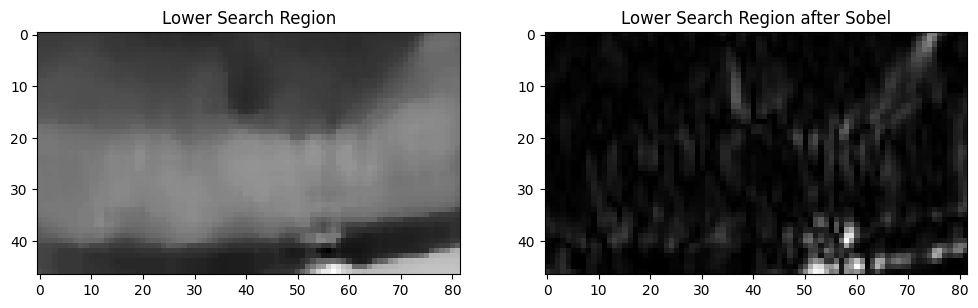

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot chosen image
axs[0].set_title("Lower Search Region")
axs[0].imshow(arr[ymin:ymax, xmin:xmax], cmap='gray')

# Plot upper search region
axs[1].set_title("Lower Search Region after Sobel")
axs[1].imshow(sobel_matrix, cmap='gray')

plt.show()

In [52]:
# Example usage:
eyelid_row_lower = None

region_of_interest = sobel_matrix

# Sum pixel values along each row to count edge points
# Sum pixel values along each row to count edge points
edge_counts = np.sum(region_of_interest, axis=1)

# Sum of all edge counts
total_edge_count = np.sum(edge_counts)

# Normalize edge counts by dividing by the total sum
edge_counts_normalized = edge_counts / total_edge_count

# Find the maximum edge count
max_edge_row_lower = int(np.argmax(edge_counts_normalized))
print(edge_counts)
print(edge_counts_normalized)
print(edge_counts_normalized[max_edge_row_lower])

# Set the threshold (between 0 and 1)

# Check if the maximum normalized edge count exceeds the threshold
if edge_counts_normalized[max_edge_row_lower] >= threshold:
    # Eyelid detected, add the boundary row to the list
    eyelid_row_lower = ymin + max_edge_row_lower
    print(edge_counts_normalized[max_edge_row_lower])

print("Eyelid Row lower:", eyelid_row_lower)


[ 617.  605.  618.  644.  613.  607.  648.  714.  770.  790.  777.  793.
  866.  947.  988.  973.  921.  885.  884.  963. 1037.  980.  936.  952.
  927.  872.  796.  727.  688.  645.  604.  595.  583.  609.  783.  997.
 1152. 1286. 1357. 1667. 1793. 1551. 1561. 1590. 1904. 2185. 1947.]
[0.01331262 0.0130537  0.0133342  0.01389518 0.01322631 0.01309686
 0.01398149 0.01540553 0.0166138  0.01704533 0.01676484 0.01711006
 0.01868514 0.02043282 0.02131745 0.02099381 0.01987184 0.01909509
 0.01907351 0.02077804 0.0223747  0.02114484 0.02019548 0.0205407
 0.02000129 0.01881459 0.01717479 0.01568602 0.01484454 0.01391676
 0.01303213 0.01283794 0.01257902 0.01314001 0.0168943  0.02151164
 0.02485598 0.02774721 0.02927913 0.03596781 0.03868643 0.03346495
 0.03368071 0.03430643 0.04108141 0.04714437 0.04200919]
0.047144367488726344
Eyelid Row lower: None


In [53]:
eyelid_row_lower,eyelid_row_upper

(None, 25)

In [54]:
if not eyelid_row_upper:
    eyelid_row_upper = yc-iris_radius
eyelid_row_upper=max(0,eyelid_row_upper)
    
if not eyelid_row_lower:
    eyelid_row_lower = yc+iris_radius
# eyelid_row_lower=max(0,eyelid_row_lower)

In [55]:
cpy_img=main_image.copy()
cv.line(cpy_img,(0,eyelid_row_upper),(cpy_img.shape[1],eyelid_row_upper),(255, 0, 255), thickness=1)
cv.line(cpy_img,(0,eyelid_row_lower),(cpy_img.shape[1],eyelid_row_lower),(255, 0, 255), thickness=1)
eyelid_row_upper,eyelid_row_lower

(25, 187)

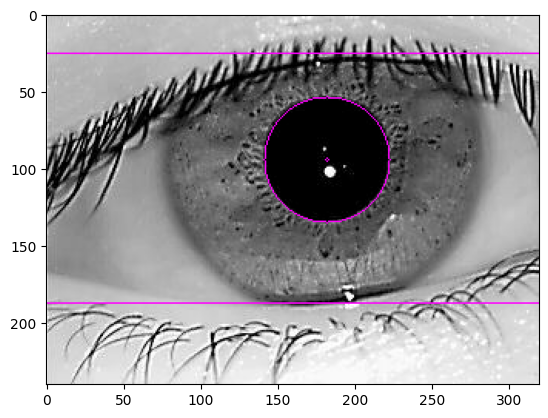

In [56]:
plt.imshow(cpy_img)

In [57]:
cv.circle(cpy_img, pupil_center, int(iris_radius), (255, 0, 255), 1)
12

12

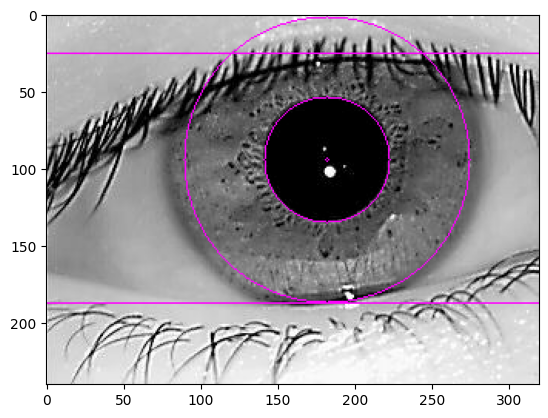

In [58]:
plt.imshow(cpy_img)

In [111]:
pupil_center,pupil_radius,iris_radius,eyelid_row_upper,eyelid_row_lower,max_edge_row_upper,max_edge_row_lower

((180, 108), 56, 98, 10, 206, 12, 15)

In [112]:
# img = main_image_backup
# hh, ww = img.shape[:2]
# hh2 = hh // 2
# ww2 = ww // 2

# # define circles
# radius1 = pupil_radius
# radius2 = iris_radius
# xc = pupil_center[0]
# yc = pupil_center[1]

# # draw filled circles in white on black background as masks
# mask1 = np.zeros_like(img)
# mask1 = cv.circle(mask1, (xc,yc), radius1, (255,255,255), -1)
# mask2 = np.zeros_like(img)
# mask2 = cv.circle(mask2, (xc,yc), radius2, (255,255,255), -1)

# # subtract masks and make into single channel
# mask = cv.subtract(mask2, mask1)

# # put mask into alpha channel of input
# result = cv.cvtColor(img, cv.COLOR_BGR2BGRA)
# result[:, :, 3] = mask[:,:,0]

# #do this?
# # result = cv.cvtColor(result, cv.COLOR_BGRA2BGR)
# # save results
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# # Display mask1
# axs[0, 0].set_title("Mask 1")
# axs[0, 0].imshow(mask1, cmap='gray')
# axs[0, 0].axis('off')  # Hide axes

# # Display mask2
# axs[0, 1].set_title("Mask 2")
# axs[0, 1].imshow(mask2, cmap='gray')
# axs[0, 1].axis('off')  # Hide axes

# # Display mask
# axs[1, 0].set_title("Mask")
# axs[1, 0].imshow(mask, cmap='gray')
# axs[1, 0].axis('off')  # Hide axes

# # Display result
# axs[1, 1].set_title("Result")
# axs[1, 1].imshow(result, cmap='gray')
# axs[1, 1].axis('off')  # Hide axes

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()

In [113]:
# hh, ww = main_image_backup.shape[:2]
# black_background = np.zeros((hh, ww, 3), dtype=np.uint8)

# # Define circles
# radius1 = pupil_radius
# radius2 = iris_radius
# xc = pupil_center[0]
# yc = pupil_center[1]

# # draw filled circles in white on black background as masks
# mask1 = cv.circle(black_background.copy(), (xc, yc), radius1, (255,255,255), -1)
# mask2 = cv.circle(black_background.copy(), (xc, yc), radius2, (255,255,255), -1)

# # Subtract masks and make into single channel
# mask = cv.subtract(mask2, mask1)

# # Apply the mask to the original image
# result = cv.bitwise_and(main_image_backup, mask)
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# # Display mask1
# axs[0, 0].set_title("Mask 1")
# axs[0, 0].imshow(mask1, cmap='gray')
# axs[0, 0].axis('off')  # Hide axes

# # Display mask2
# axs[0, 1].set_title("Mask 2")
# axs[0, 1].imshow(mask2, cmap='gray')
# axs[0, 1].axis('off')  # Hide axes

# # Display mask
# axs[1, 0].set_title("Mask")
# axs[1, 0].imshow(mask, cmap='gray')
# axs[1, 0].axis('off')  # Hide axes

# # Display result
# axs[1, 1].set_title("Result")
# axs[1, 1].imshow(result, cmap='gray')
# axs[1, 1].axis('off')  # Hide axes

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()

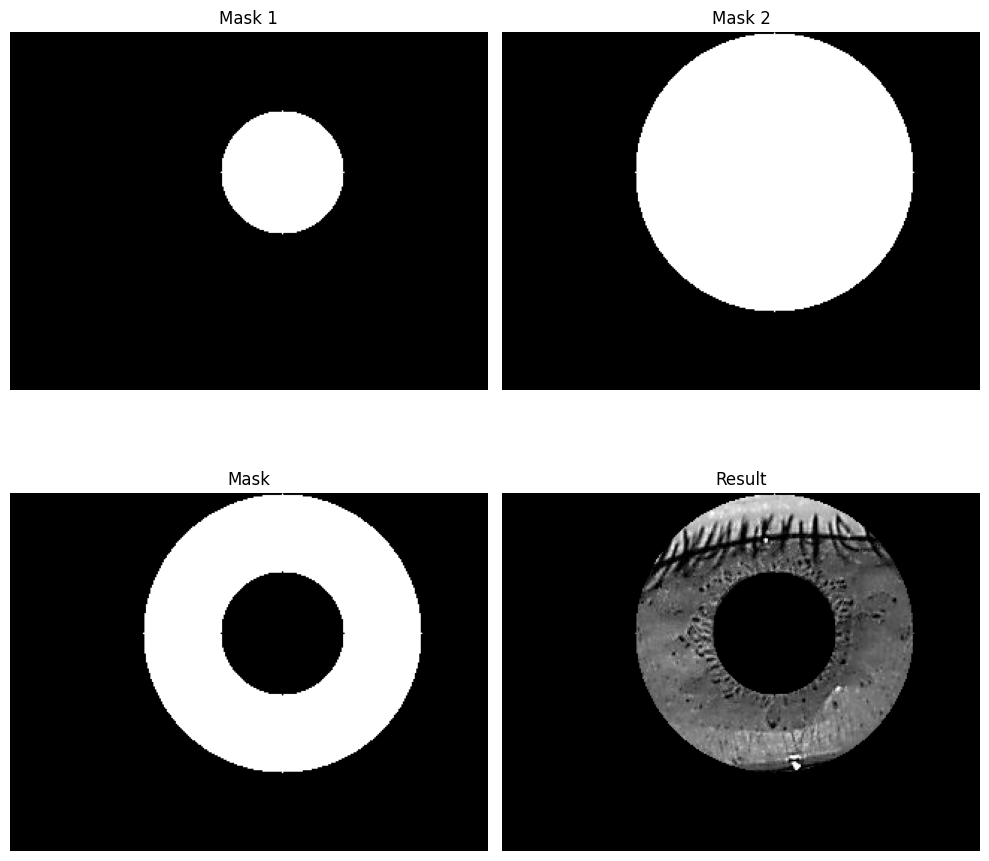

In [59]:
hh, ww = main_image_backup.shape[:2]
black_background = np.zeros((hh, ww), dtype=np.uint8)

# Define circles
radius1 = pupil_radius
radius2 = iris_radius
xc = pupil_center[0]
yc = pupil_center[1]

# draw filled circles in white on black background as masks
mask1 = cv.circle(black_background.copy(), (xc, yc), radius1, 255, -1)
mask2 = cv.circle(black_background.copy(), (xc, yc), radius2, 255, -1)

# Subtract masks and make into single channel
mask = cv.subtract(mask2, mask1)

# Apply the mask to the original image
result = cv.cvtColor(main_image_backup, cv.COLOR_BGR2GRAY)
result = cv.bitwise_and(result, mask)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display mask1
axs[0, 0].set_title("Mask 1")
axs[0, 0].imshow(mask1, cmap='gray')
axs[0, 0].axis('off')  # Hide axes

# Display mask2
axs[0, 1].set_title("Mask 2")
axs[0, 1].imshow(mask2, cmap='gray')
axs[0, 1].axis('off')  # Hide axes

# Display mask
axs[1, 0].set_title("Mask")
axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].axis('off')  # Hide axes

# Display result
axs[1, 1].set_title("Result")
axs[1, 1].imshow(result, cmap='gray')
axs[1, 1].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [115]:
result.shape

(240, 320)

In [116]:
# if max_edge_row_upper:
#     result = result[max_edge_row_upper:,:]
# if max_edge_row_lower:
#     result = result[:max_edge_row_lower,:]

In [60]:
(xc,yc),pupil_center,pupil_radius,iris_radius,eyelid_row_upper,eyelid_row_lower,max_edge_row_upper,max_edge_row_lower

((182, 94), (182, 94), 41, 93, 25, 187, 24, 45)

In [61]:
if eyelid_row_upper is not None:
    result = result[eyelid_row_upper:, :]
    a = eyelid_row_upper
else:
    result = result[yc - iris_radius:, :]
    a = yc - iris_radius

# a=max(0,a)
a,eyelid_row_lower

(25, 187)

In [62]:
if eyelid_row_lower:
    result = result[: eyelid_row_lower-a, :]
else:
    result = result[:iris_radius-a, :]

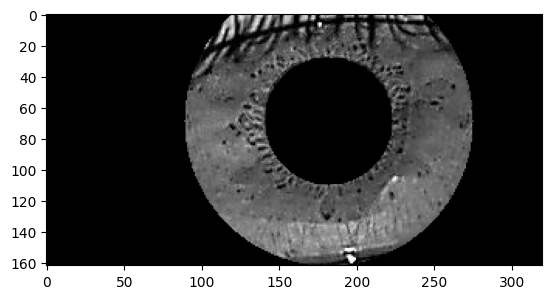

In [63]:
plt.imshow(result,cmap='gray')

In [64]:
result=result[:,xc-iris_radius:xc+iris_radius]

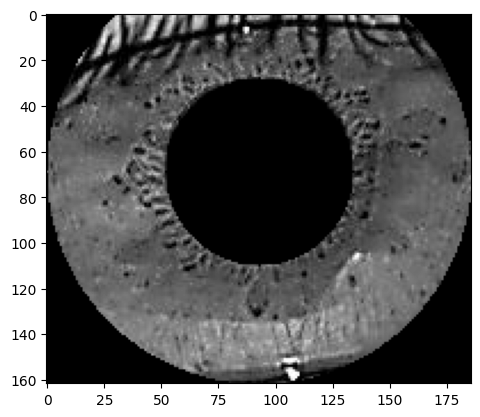

In [65]:
plt.imshow(result,cmap='gray')

In [66]:
image_path = os.path.join("Images", "image1.png")

image_path

'Images/image1.png'

In [67]:
cv.imwrite(image_path, result)

True

In [68]:
a,b=result.shape
a,b

(162, 186)

In [69]:
xc,yc=result.shape[0]//2,result.shape[1]//2
xc,yc,pupil_radius,iris_radius

(81, 93, 41, 93)

In [70]:
r1=pupil_radius
r2=min(yc,iris_radius)

In [1]:
def rubber_sheet_mapping(iris_image, r1, r2,xc,yc, radial_resolution):
    # Convert iris image to grayscale
    gray = iris_image
    
    # Find pupil center (you can use your method for this)
    pupil_center = (xc, yc)  # Example values, replace with actual calculation
    
    # Define parameters for rubber sheet mapping
    theta_steps = 360  # Number of angular steps
    theta_range = np.linspace(0, 2*np.pi, theta_steps)
    
    # Initialize normalized iris image
    # normalized_iris = np.zeros((radial_resolution, theta_steps), dtype=np.uint8)
    normalized_iris = np.zeros((r2-r1, theta_steps), dtype=np.uint8)
    # Perform rubber sheet mapping
    for r in range(radial_resolution):
        for theta_idx, theta in enumerate(theta_range):
            # Calculate coordinates in polar representation
            x_polar = pupil_center[0] + (r1+r) * np.cos(theta)
            y_polar = pupil_center[1] + (r1+r) * np.sin(theta)
             # Ensure coordinates are within image bounds
            x_polar = max(0, min(gray.shape[1] - 1, int(x_polar)))
            y_polar = max(0, min(gray.shape[0] - 1, int(y_polar)))           
            # Interpolate pixel value from original iris image
            normalized_iris[r, theta_idx] = gray[int(y_polar), int(x_polar)]
    
    return normalized_iris

# Example usage
iris_image = result  # Replace with path to your iris image
r1 = pupil_radius  # Example value, replace with actual pupil radius
r2 = iris_radius  # Example value, replace with actual iris radius
radial_resolution = r2-r1  # Adjust based on your requirements

normalized_iris = rubber_sheet_mapping(iris_image, r1, r2,xc,yc, radial_resolution)

# Display normalized iris image


NameError: name 'result' is not defined

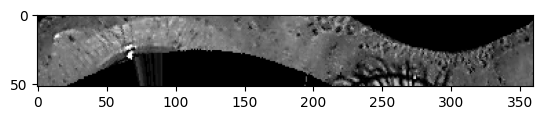

In [72]:
plt.imshow(normalized_iris,cmap='gray')

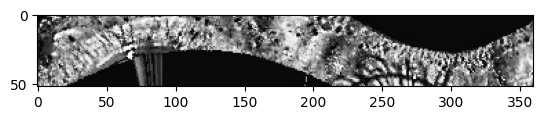

In [73]:
    # Apply adaptive histogram equalization
clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
enhanced_iris = clahe.apply(normalized_iris)

plt.imshow(enhanced_iris,cmap='gray')


In [ ]:
# #sqaure by adding pixels
# height, width = result.shape
# max_dimension = max(height, width)
# dir_add = 0 if height-width<0 else 1  #0 means add horizontal rows
# add_num = abs(height-width)

# if dir_add == 0:
#     # Add horizontal rows
#     padding_top = add_num // 2
#     padding_bottom = add_num - padding_top
#     padding_top_array = np.zeros((padding_top, result.shape[1]), dtype=np.uint8)
#     padding_bottom_array = np.zeros((padding_bottom, result.shape[1]), dtype=np.uint8)
#     result = np.vstack((padding_top_array, result, padding_bottom_array))
# else:
#     # Add vertical columns
#     padding_left = add_num // 2
#     padding_right = add_num - padding_left
#     padding_left_array = np.zeros((result.shape[0], padding_left), dtype=np.uint8)
#     padding_right_array = np.zeros((result.shape[0], padding_right), dtype=np.uint8)
#     result = np.hstack((padding_left_array, result, padding_right_array))

    

In [ ]:
print(result.shape)
plt.imshow(result,cmap='gray')

In [ ]:
random_file_path

In [ ]:
enhanced_iris=cv.cvtColor(enhanced_iris,cv.COLOR_BGR2RGB)
enhanced_iris.shape

In [ ]:
some=random_file_path.split("/")
some

In [ ]:
# save=os.path.join("Images",f"{file1}{file2}.bmp")
# cv.imwrite(save,enhanced_iris)
# save

In [ ]:
# height, width = result.shape

# new_img=np.zeros(result.shape,dtype=np.uint8).reshape(height,-1)

# I think minimum of eyelid should be taken and then we crop to make rectangular

new iris radius = min(iris_radius,pupil_radius-max_edge_row_lower,pupil_radius+max_edge_row_upper)

In [ ]:
# plt.imshow(new_image,cmap='gray')